### Makes width larger for Jupyter notebook

In [1]:
from IPython.core.display import HTML,Markdown

HTML("""
<style>
.container { width:100% !important; }
</style>
""")

# Goal of Video:
* Create Mini AI Trading Assistant
* Agentic RAG: a framework designed to build research agents skilled in tool use, reasoning, and decision-making with your data.

* Explain tool calling which is part of routing or selecting between tools in agentic rag.
* Implement tool calling for 
    - Getting portfolio value
    - Getting number of open orders
    - Cancelling all open orders
    - Placing buy/sell limit or
    - Get current price of a stock
    - Getthe stock charts
    - Asking questions about stock news (from previous vid   -

### Prerequisites

#### 1. RAG from Scratch using Llama Index

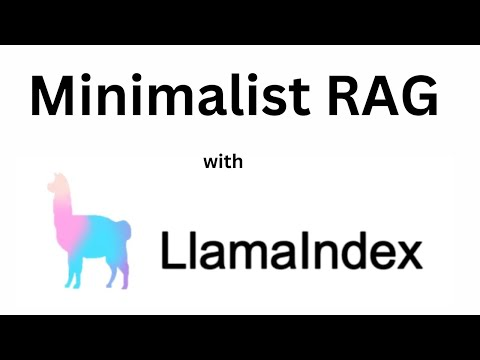

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('cspMvs9QavM',width=800,height=500)

#### 2. Tutorial on ib-asnyc / ib-insnyc

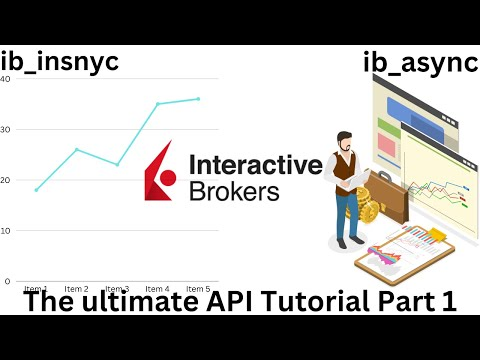

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('_AASJZyNcXQ',width=800,height=500)

## OpenAI key
* We will use openai models so we need to have the openai key
Make sure you have your openai api key set in os.environ['OPENAI_API_KEY'] since by default it looks there
* Get key here: https://openai.com/index/openai-api/
* Set os.environ['OPENAI_API_KEY']  = YOUR_API_KEY

### Settings
* Selecting LLM and Embedding Model to Use and putting it in Settings
* It is more expensive, but I recommend using gpt-4-turbo over gpt-4-o for the rag part otherwise sometimes you get worse answers.

In [58]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

Settings.llm = OpenAI(model='gpt-4-turbo')
Settings.embed_model = OpenAIEmbedding()


## Tool Calling aka Function Calling

* Pick a function from a list of functions to use based on query.
* Infer argument to pass to function based on the query.
* Call llm.predict_and_call on your list of tools with the query and get back the relevent function along with its arguments. 
* Core LLAMA index abstraction is **FunctionTool.from_defaults**
    - Wraps any given Python function
    - Type annotations + docstring are important since they are used as a prompt

##### Load function tool

In [59]:
from llama_index.core.tools import FunctionTool

### Most basic example of tool calling
1. Define tools
   * Important type annotation + docstring since these will be used in LLM prompt to infer tool to use and params to use

In [60]:
def add(a:int,b:int)->int:
    "Returns sum of inputs"
    return a + b
def square(a:int)->int:
    return a**2

add_tool = FunctionTool.from_defaults(fn=add)
square_tool = FunctionTool.from_defaults(fn=square)

In [61]:
from llama_index.llms.openai import OpenAI
llm = OpenAI(model = 'gpt-4-turbo')

In [62]:
query = "Square 3"

response=llm.predict_and_call(
    tools=[add_tool,square_tool],
    user_msg=query
)

In [63]:
response.response

'9'

* Can use response.sources[0].raw_output to get output with type you want

In [64]:
response.sources[0].raw_output

9

In [65]:
query = "Add 4 and 6"

response=llm.predict_and_call(
    tools=[add_tool,square_tool],
    user_msg=query
)
response.sources[0].raw_output

10

* Verbose= True shows thought process

In [66]:
query = "Add 4 and 6"

llm.predict_and_call(
    tools=[add_tool,square_tool],
    user_msg=query,verbose=True
)


=== Calling Function ===
Calling function: add with args: {"a": 4, "b": 6}
=== Function Output ===
10


AgentChatResponse(response='10', sources=[ToolOutput(content='10', tool_name='add', raw_input={'args': (), 'kwargs': {'a': 4, 'b': 6}}, raw_output=10, is_error=False)], source_nodes=[], is_dummy_stream=False)

##### Other Imports needed

In [67]:
import plotly.express as px
from plotly.graph_objs import Figure
from ib_async import *

#### IB Setup 
* Sign in with ib-gateway
* Load ib_async and ib_insnyc ports/clientIds, but don't connect yet


In [68]:
ib = IB()
util.startLoop()
PORT=4003
CLIENT_ID=5

## Functions ("Tools") to Implement

#### Portfolio value

In [69]:
def portfolio_value()->str:
    """ Gives the value of your portfolio """
    ib.connect(port=PORT,clientId=CLIENT_ID)
    portfolio_value = [value.value for value in ib.accountSummary() if value.tag=='NetLiquidation'][0]
    ib.disconnect()
    return f"Your portfolio is worth ${float(portfolio_value):,.2f}"

portfolio_tool = FunctionTool.from_defaults(portfolio_value)


#### Open Orders

In [70]:
def open_orders()->str:
    """Gives the number of open orders"""
    ib.connect(port=PORT,clientId=CLIENT_ID)
    num_open_orders = len([trade for trade in ib.openTrades() if 'cancel' not in trade.orderStatus.status.lower()])
    ib.disconnect()
    return f"You have {num_open_orders} open orders"

open_order_tool = FunctionTool.from_defaults(fn=open_orders)


#### Cancel Order

In [71]:
def cancel_open_orders() -> str:
    """Cancels all your open orders"""
    ib.connect(port=PORT,clientId=CLIENT_ID)
    for order in ib.openOrders():
        ib.cancelOrder(order)
    ib.disconnect()
    return "We cancelled all your open orders"
    
cancel_order_tool = FunctionTool.from_defaults(fn=cancel_open_orders)


#### Trade Tool: Buying or selling stock

In [72]:
def trade_stock(action:str,symbol:str,num_shares:int,limit_price:float)->str:
    """Buy or sell num_shares of symbol at limit price"""
    ib.connect(port=PORT,clientId=CLIENT_ID)
    order = LimitOrder(action,num_shares,limit_price)
    stock = Stock(symbol=symbol,exchange='SMART',currency='USD')
    ib.qualifyContracts(stock)
    trade = ib.placeOrder(stock,order)
    ib.disconnect()
    return f"Order with ID {trade.order.orderId} is submitted!"

trade_tool = FunctionTool.from_defaults(fn=trade_stock)


#### Current stock price tool

In [73]:
def get_current_stock_price(symbol)->str:
    """ Get current stock price of symbol """
    ib.connect(port=PORT,clientId=CLIENT_ID)
    stock = Stock(symbol=symbol,exchange='SMART',currency='USD')
    ib.qualifyContracts(stock)
    ticker = ib.reqMktData(contract=stock,genericTickList="",snapshot=True,regulatorySnapshot=False)
    ib.sleep(1)
    mkt_price = ticker.marketPrice()
    ib.disconnect()
    return f"{symbol} is currently trading at {mkt_price:,.2f}"

current_stock_price_tool = FunctionTool.from_defaults(fn=get_current_stock_price)


### Chart of stock tool

In [74]:
def get_stock_chart(symbol:str,bar_size:int,bar_size_unit:str,duration:int,duration_unit:str,use_rth:bool)->Figure:
    """Get current stock chart for ticker symbol for bar_size for last duration and use regular trading hours as default
       When specifying a unit, historical data request duration format is integer{SPACE}unit (S|D|W|M|Y)
    """

    durationStr = str(duration)+" "+duration_unit
    
    barSizeSetting = str(bar_size) +" "+bar_size_unit+('s'if duration>1 else '')
    
    
    ib.connect(port=PORT,clientId=CLIENT_ID)
    stock = Stock(symbol=symbol,exchange='SMART',currency='USD')
    ib.qualifyContracts(stock)
    bars = ib.reqHistoricalData(stock,"",durationStr=durationStr,barSizeSetting=barSizeSetting,whatToShow='TRADES',useRTH=use_rth)
    df = util.df(bars)
    fig = px.line(df,x='date',y='close')
    ib.disconnect()
    return fig

stock_chart_tool = FunctionTool.from_defaults(fn=get_stock_chart)
 


## Get Query Engine from the Rag from Scratch Video to create Vector Query Tool!

In [75]:
import pandas as pd
from llama_index.core import Document, VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
     
def get_query_engine_from_last_video():
    df = pd.read_csv("https://raw.githubusercontent.com/adidror005/youtube-videos/main/small_news_dataset%20(1).csv")   
    documents = []
    for index, row in df.iterrows():
        text=row['content']
        row_dict = row.to_dict()
        meta_data_dict = {k:v for k,v in row_dict.items() if k in ['created_at','author']}
        documents.append(Document(text=text,metadata=meta_data_dict))
    parser = SentenceSplitter(chunk_size=512,chunk_overlap=64)
    nodes = parser.get_nodes_from_documents(documents)
    index = VectorStoreIndex(nodes)
    query_engine = index.as_query_engine(
        response_mode='tree_summarize',similarity_top_k=3
    )
    return query_engine

In [76]:
query_engine = get_query_engine_from_last_video()

In [77]:
def get_vector_query_response(query:str)->str:
    response=query_engine.query(query)
    return response.response


In [78]:
vector_query_tool = FunctionTool.from_defaults(
    name='vector_tool',
    fn = get_vector_query_response
)

### Put all tools together

In [79]:
tool_list = [portfolio_tool,open_order_tool,cancel_order_tool,trade_tool,current_stock_price_tool,stock_chart_tool,vector_query_tool]
    

#### Test example with verbose = True

In [80]:
query = 'What is TSLA current price'

response = llm.predict_and_call(
            tools=tool_list,
            user_msg=query, 
            verbose=True
        )

=== Calling Function ===
Calling function: get_current_stock_price with args: {"symbol": "TSLA"}
=== Function Output ===
TSLA is currently trading at 174.17


In [81]:
response.response

'TSLA is currently trading at 174.17'

In [82]:
response.sources[0].raw_output

'TSLA is currently trading at 174.17'

In [83]:
query = 'Give me 5 min chart for TSLA last 3 days'

response = llm.predict_and_call(
            tools=tool_list,
            user_msg=query, 
            verbose=True
        )

=== Calling Function ===
Calling function: get_stock_chart with args: {"symbol": "TSLA", "bar_size": 5, "bar_size_unit": "min", "duration": 3, "duration_unit": "D", "use_rth": true}
=== Function Output ===
Figure({
    'data': [{'hovertemplate': 'date=%{x}<br>close=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2024, 6, 6, 9, 30, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),
                          datetime.datetime(2024, 6, 6, 9, 35, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),
                          datetime.datetime(2024, 6, 6, 9, 40, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),
                          ...,
                          datetime.datetime(2024, 6, 10, 1

In [84]:
response.response

"Figure({\n    'data': [{'hovertemplate': 'date=%{x}<br>close=%{y}<extra></extra>',\n              'legendgroup': '',\n              'line': {'color': '#636efa', 'dash': 'solid'},\n              'marker': {'symbol': 'circle'},\n              'mode': 'lines',\n              'name': '',\n              'orientation': 'v',\n              'showlegend': False,\n              'type': 'scatter',\n              'x': array([datetime.datetime(2024, 6, 6, 9, 30, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),\n                          datetime.datetime(2024, 6, 6, 9, 35, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),\n                          datetime.datetime(2024, 6, 6, 9, 40, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),\n                          ...,\n                          datetime.datetime(2024, 6, 10, 15, 45, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),\n                          datetime.datetime(2024, 6, 10, 15, 50, tzinfo=zoneinfo.ZoneInfo(key='US/Eastern')),\n                          d

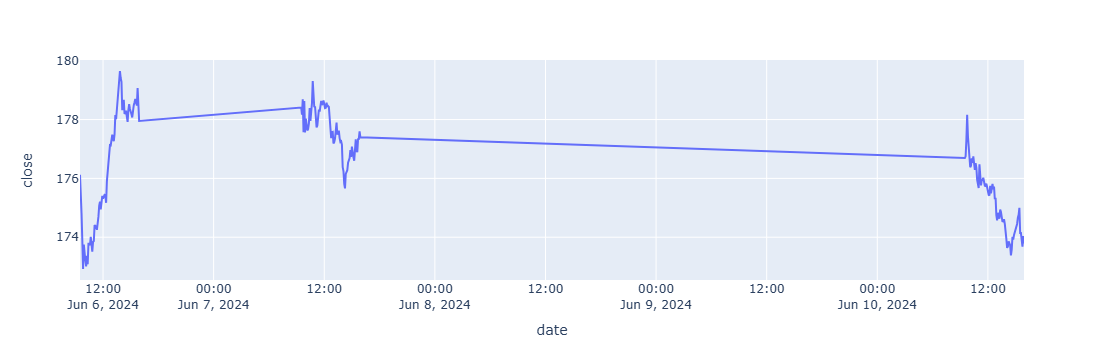

In [85]:
response.sources[0].raw_output

In [87]:
query = "As a tesla investor what is a key upcoming date I should be concerned about"
response = llm.predict_and_call(
            tools=tool_list,
            user_msg=query, 
            verbose=True
        )


=== Calling Function ===
Calling function: vector_tool with args: {"query": "key upcoming date for Tesla investors"}
=== Function Output ===
The key upcoming date for Tesla investors is June 13, 2024, when the annual shareholder meeting is scheduled to take place.


## Simple Text Input Widget UI with Panel
* I love Ipywidgets, but it seems to not work so well with new versions of Jupyter/Jupyerlab
* Out of scope of video to talk about panel widgets, but main thing is lok at the *response = llm.predict_and_call* part

In [89]:
import panel as pn
from IPython.display import Markdown
from panel.layout import HSpacer
from llama_index.core.base.response.schema import Response

pn.extension()


# Container for output with Markdown styling
output = pn.Column(sizing_mode="stretch_width")

# Function to be called when Enter is pressed
def ask_ai_agent(event):
    global res
    query = event.new
    output.clear()

    # Create Markdown components with styling
    query_md = pn.pane.Markdown(f"#### Query: {query}")
    response_md = pn.pane.Markdown(f"")
    
    # Styling for query and response
    query_md.margin = (20, 0, 0, 0)  # Top margin only for query
    
    output.append(query_md)
    output.append(HSpacer())  # Spacer for visual separation
    output.append(response_md)

    try:
        response = llm.predict_and_call(
            tool_list,
            query, verbose=False
        )
        res = response.sources[0].raw_output

        if isinstance(res, str):
            response_md.object = res  # Update the response Markdown's content
        elif isinstance(res,Response):
            response_md.object = res.response  # Update the response Markdown's content
        else:
            output.append(pn.pane.Plotly(res))
            #res.show()


    except Exception as e:
        response_md.object = f"Error: {e}"  # Update for errors

# Text input widget
text_input = pn.widgets.TextInput(name='Ask me Any Question', placeholder='Enter a string here...', width=400)
text_input.param.watch(ask_ai_agent, 'value')

# Display the widget and output
pn.Column(text_input, output).servable()

Column
    [0] TextInput(name='Ask me Any Question', placeholder='Enter a string here...', width=400)
    [1] Column(sizing_mode='stretch_width')

### References
* deeplearning.ai Agentic Rag short course